In [75]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier

# Success Prediction
- Predict success or not with information before project begins
- Features : target_money, grammar_level, has_video, funding_type_count, funding_type_1, funding_type_2, funding_type_3, funding_duration


### ※ Estimation of grammar_level
- number of errors / number of tokens
- tested by *naver grammar tester* (https://github.com/ssut/py-hanspell)
- suppposed grammar level represents capacity of creators

## Outline
- Check the insight from previous project (https://github.com/surprisoh/crowdfunding_prediction)
- Distribution test
- Feature selection
- Model Selection (classification)
- Grid Search
- Optimal model selection
- Result & Insight

## 1. Distribution Test

In [1]:
# user_data load
cf_users = pd.read_excel('tb_users_0410.xlsx')

In [26]:
#load_data
cf_df = pd.read_excel('cf_df_final_5.xlsx')

In [27]:
#check feature number
def check_number(feature):
    """"feature : 'str'"""
    count = cf_df[feature].value_counts()
    return print(count)

In [28]:
check_number('category')

publishing           420
music                298
design               278
movie/video          269
game                 249
art                  228
theater              138
comics               107
photo                 73
comics publishing     48
tech                  44
fashion               40
dance                 18
etc                    2
Name: category, dtype: int64


In [29]:
# number of success
check_number('end_with_success')

True     1379
False     833
Name: end_with_success, dtype: int64


In [30]:
# success rate
print('overall success'),
print('=================='),
success_percentage = cf_df['end_with_success'].value_counts()[1] / cf_df['end_with_success'].count()
print(round(success_percentage*100, 2),'%' )

overall success
62.34 %


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


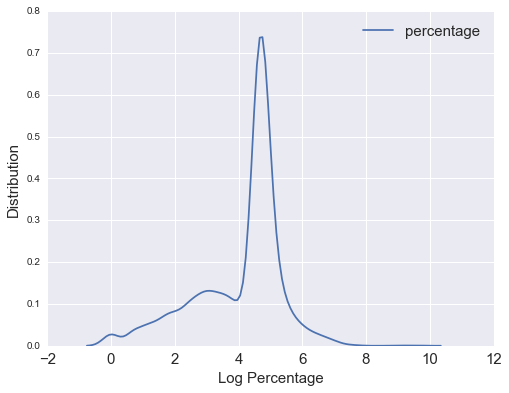

In [31]:
# percentage distribution
#log scailing
plt.figure(figsize=(8, 6))
sns.kdeplot(cf_df['percentage'].apply(lambda x: np.log(x)));
plt.legend(fontsize = 15);
plt.xticks(fontsize=15);
plt.xlabel('Log Percentage', fontsize=15);
plt.ylabel('Distribution', fontsize=15);

### category

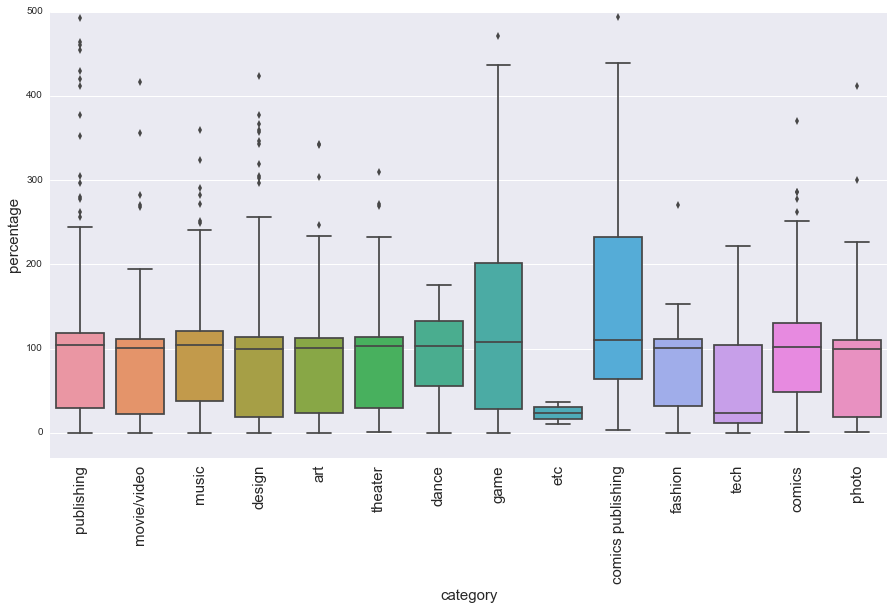

In [32]:
# percentage boxplot by categories
figure = plt.figure(figsize=(15,8))
sns.boxplot(x = cf_df['category'], y = cf_df['percentage']);
plt.xticks(rotation = 'vertical');
plt.ylim(-30, 500);
plt.xticks(fontsize=15);
plt.xlabel('category', fontsize=15);
plt.ylabel('percentage', fontsize=15);

In [33]:
# success rate by categories
print('success'),
print('=================='),
for i in cf_df['category'].unique():
    success_percentage = (len(cf_df.loc[cf_df['category'] == i][cf_df['end_with_success'] == True]) / \
    len(cf_df.loc[cf_df['category'] == i]))*100
    print("{category} :".format(category = i), round(success_percentage, 2),'%')
print('=================='),
print(u'dance가 가장 높음')

success
publishing : 65.48 %
movie/video : 62.45 %
music : 70.47 %
design : 52.52 %
art : 59.65 %
theater : 71.74 %
dance : 72.22 %
game : 59.84 %
etc : 0.0 %
comics publishing : 70.83 %
fashion : 50.0 %
tech : 36.36 %
comics : 69.16 %
photo : 53.42 %
dance가 가장 높음


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


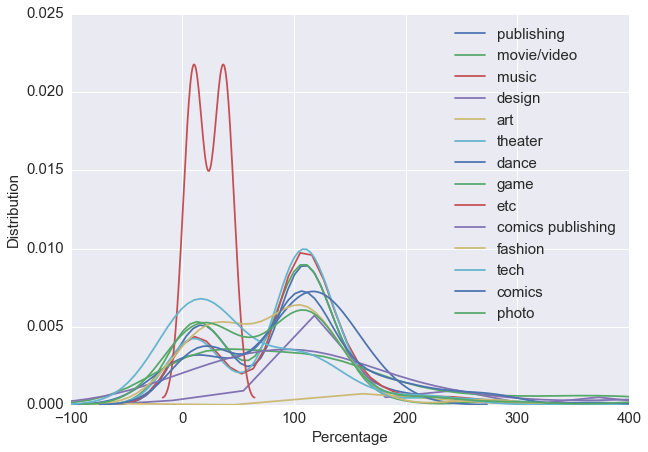

In [34]:
# category percentage distribution
figure = plt.figure(figsize=(10,7))
for i in cf_df['category'].unique():
    sns.kdeplot(cf_df.loc[cf_df['category'] == '{i}'.format(i=i)]['percentage'], label = '{i}'.format(i=i))
    plt.xlim(-100, 400);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Percentage', fontsize=15)
plt.ylabel('Distribution', fontsize=15)
plt.legend(fontsize = 15);

In [35]:
# 전체 분산과 각 category 분산과의 분포 차이 검정
# K-S : Kolmogorov Smirnov test
for i in cf_df['category'].unique()[:-1]:
    all_data = cf_df['funding_rate']
    category_data = cf_df.loc[cf_df['category'] == i]['funding_rate']
    # p-value < 0.05 인것만 출력
    if round(sp.stats.ks_2samp(all_data, category_data)[1], 4) < 0.05:
        print('[all_sample vs {category_i}]'.format(category_i = i)),
        print('  K-S statistic :', round(sp.stats.ks_2samp(all_data, category_data)[0], 4))
        print('  p-value :', round(sp.stats.ks_2samp(all_data, category_data)[1], 4))

[all_sample vs movie/video]
  K-S statistic : 0.0988
  p-value : 0.0172
[all_sample vs music]
  K-S statistic : 0.0876
  p-value : 0.0334
[all_sample vs design]
  K-S statistic : 0.0997
  p-value : 0.0136
[all_sample vs game]
  K-S statistic : 0.2137
  p-value : 0.0
[all_sample vs comics publishing]
  K-S statistic : 0.2354
  p-value : 0.0089
[all_sample vs tech]
  K-S statistic : 0.2955
  p-value : 0.0008


분포로도 카테고리 구분 가능

### video

In [36]:
# video by category
print('video'),
print('=================='),
for i in cf_df['category'].unique():
    video = (len(cf_df.loc[cf_df['category'] == i][cf_df['has_video'] == True]) / \
    len(cf_df.loc[cf_df['category'] == i]))*100
    print("{category} :".format(category = i), round(video, 2),'%')
overall = len(cf_df.loc[cf_df['has_video'] == True]) / len(cf_df)
print('overall :', round(overall, 2)*100, '%')

video
publishing : 25.0 %
movie/video : 60.59 %
music : 50.34 %
design : 27.34 %
art : 26.75 %
theater : 39.86 %
dance : 66.67 %
game : 32.93 %
etc : 50.0 %
comics publishing : 12.5 %
fashion : 22.5 %
tech : 38.64 %
comics : 4.67 %
photo : 21.92 %
overall : 34.0 %


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [37]:
# number 0f video
check_number('has_video')

False    1454
True      758
Name: has_video, dtype: int64


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


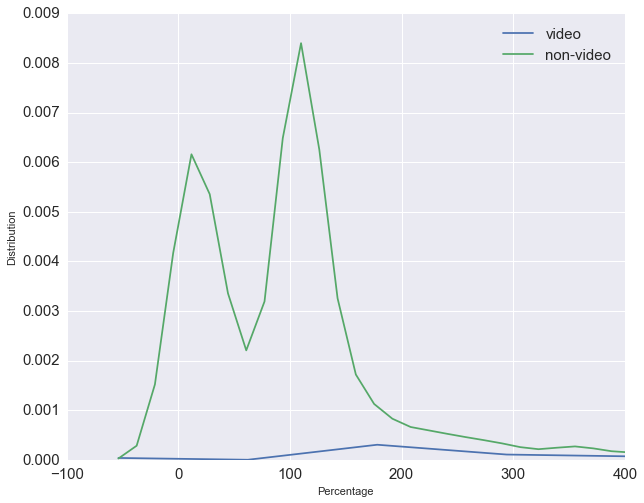

In [38]:
# percentage distribution by video status
figure = plt.figure(figsize=(10,8))
sns.kdeplot(cf_df[cf_df['has_video'] == True]['percentage'], label= 'video')
sns.kdeplot(cf_df[cf_df['has_video'] == False]['percentage'], label= 'non-video')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Percentage')
plt.ylabel('Distribution')
plt.xlim(-100, 400)
plt.legend(fontsize = 15)

In [39]:
# normality test
video_percent = cf_df[cf_df['has_video'] == True]['percentage']
no_video_percent = cf_df[cf_df['has_video'] == False]['percentage']
print('[video vs no_video]'),
print('Shapiro test statistics(video) :', sp.stats.shapiro(video_percent)[0],
'  ','Shapiro test p-value(video) :', sp.stats.shapiro(video_percent)[1])
print('Shapiro test statistics(no_video) :', sp.stats.shapiro(no_video_percent)[0],
'  ','Shapiro test p-value(no_video) :', sp.stats.shapiro(no_video_percent)[1])

[video vs no_video]
Shapiro test statistics(video) : 0.07845711708068848    Shapiro test p-value(video) : 0.0
Shapiro test statistics(no_video) : 0.5601882934570312    Shapiro test p-value(no_video) : 0.0


In [40]:
print(sp.stats.ks_2samp(video_percent, no_video_percent))
print(sp.stats.mannwhitneyu(video_percent, no_video_percent))

Ks_2sampResult(statistic=0.063222917037160653, pvalue=0.03562431845949008)
MannwhitneyuResult(statistic=551498.0, pvalue=0.97582000149086479)


정규분포를 따르지 않는다.
두 분포는 다른 분포이지만 평균은 차이가 없다

In [41]:
cf_df.columns

Index(['category', 'end_with_success', 'has_video', 'id', 'target_money',
       'percentage', 'permalink', 'title', 'num_funding_type',
       'funding_type_1', 'funding_type_2', 'funding_type_3',
       'funding_duration', 'current_money', 'start_year', 'start_month',
       'funding_rate', 'grammar_level', 'lower_category', 'category_label'],
      dtype='object')

## count, funding_duration, month, grammar_level

current, target money

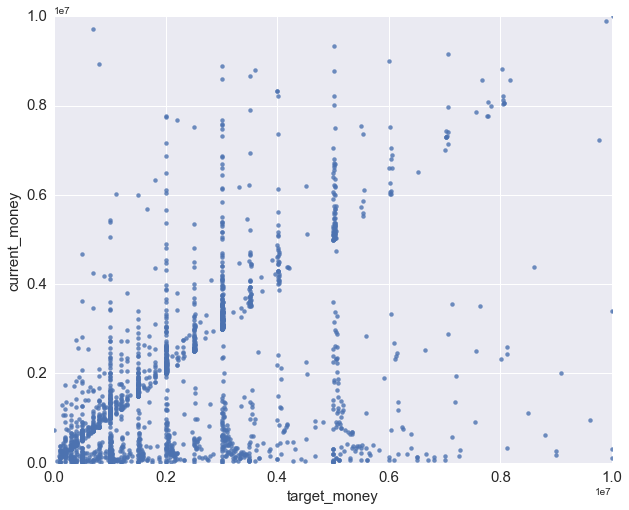

In [42]:
# target_money, current_money
figure = plt.figure(figsize=(10,8))
sns.regplot(x ='target_money', y ='current_money', data = cf_df, fit_reg=False);
plt.xlim(-1000, 10000000);
plt.ylim(-2000, 10000000);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('target_money', fontsize = 15);
plt.ylabel('current_money', fontsize = 15);

In [43]:
#Pearson Correlation
target_current_corr = sp.stats.pearsonr(cf_df['target_money'].tolist(), cf_df['current_money'].tolist())
print('Pearson correlation :', round(target_current_corr[0], 4))

Pearson correlation : 0.3636


선형관계가 있다

grammar

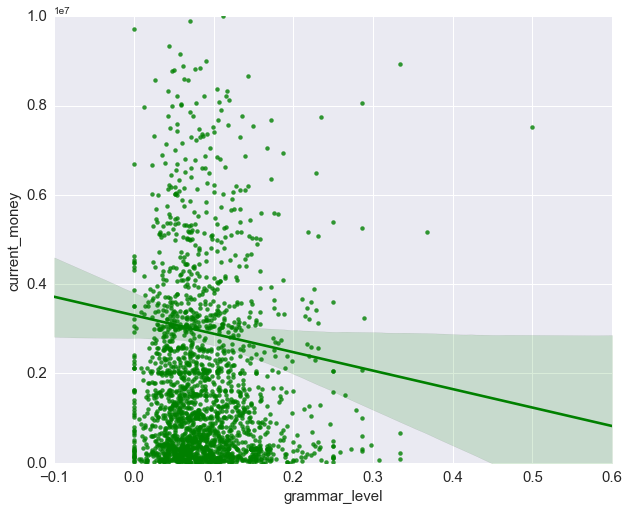

In [44]:
figure = plt.figure(figsize=(10,8));
sns.regplot(cf_df['grammar_level'], cf_df['current_money'], color='g');
plt.ylim(-1000, 10000000);
plt.xticks(fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('grammar_level', fontsize = 15);
plt.ylabel('current_money', fontsize = 15);

In [45]:
#Pearson Correlation
grammar_current_corr = sp.stats.pearsonr(cf_df['grammar_level'].tolist(), cf_df['current_money'].tolist())
print('Pearson correlation :', round(grammar_current_corr[0], 4))

Pearson correlation : -0.0347


(-) correlation을 보이지만 수치가 매우 낮아 의미없을지도?

grammar

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


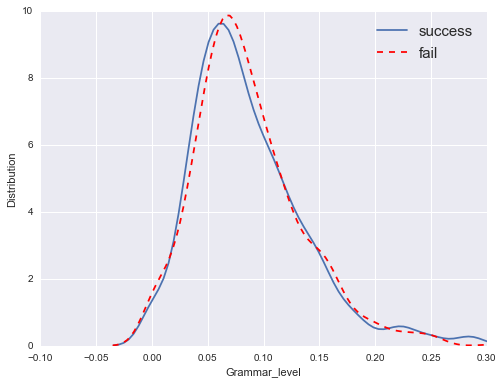

In [46]:
figure = plt.figure(figsize=(8,6))
sns.kdeplot(cf_df[cf_df['end_with_success'] == True]['grammar_level'], label= 'success');
sns.kdeplot(cf_df[cf_df['end_with_success'] == False]['grammar_level'], label= 'fail',
            c='r', linestyle='--');
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel('Grammar_level');
plt.ylabel('Distribution');
plt.xlim(-0.1, 0.3);
plt.legend(fontsize = 15);

In [47]:
success_grammar = cf_df[cf_df['end_with_success'] == True]['grammar_level']
fail_grammar = cf_df[cf_df['end_with_success'] == False]['grammar_level']
print('Shapiro test statistics(success_grammar) :', round(sp.stats.shapiro(success_grammar)[0], 4),
'  ','Shapiro test p-value(success_grammar) :', round(sp.stats.shapiro(success_grammar)[1], 4)),
print('Shapiro test statistics(fail_grammar) :', round(sp.stats.shapiro(fail_grammar)[0], 4),
'  ','Shapiro test p-value(fail_grammar) :', round(sp.stats.shapiro(fail_grammar)[1], 4))

Shapiro test statistics(success_grammar) : 0.8984    Shapiro test p-value(success_grammar) : 0.0
Shapiro test statistics(fail_grammar) : 0.943    Shapiro test p-value(fail_grammar) : 0.0


정규분포를 따르지않는다.

In [48]:
print(sp.stats.ks_2samp(success_grammar, fail_grammar))
print(sp.stats.mannwhitneyu(success_grammar, fail_grammar))

Ks_2sampResult(statistic=0.038506773267682703, pvalue=0.41761203150318038)
MannwhitneyuResult(statistic=565210.0, pvalue=0.52986405927622593)


count, funding_duration, month

num_funding_type

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


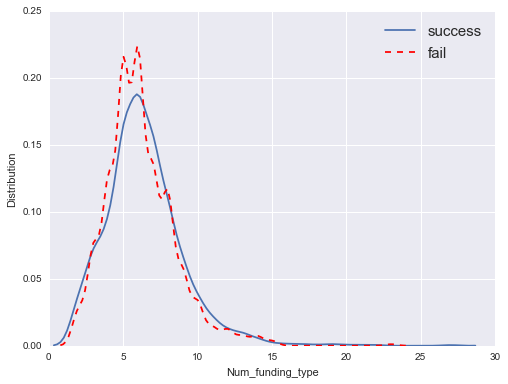

In [50]:
figure = plt.figure(figsize=(8,6))
sns.kdeplot(cf_df[cf_df['end_with_success'] == True]['num_funding_type'], label= 'success');
sns.kdeplot(cf_df[cf_df['end_with_success'] == False]['num_funding_type'], label= 'fail',
            c='r', linestyle='--');
plt.xticks(fontsize=10);
plt.yticks(fontsize=10);
plt.xlabel('Num_funding_type');
plt.ylabel('Distribution');
#plt.xlim(-0.1, 0.3);
plt.legend(fontsize = 15);

In [51]:
success_count = cf_df[cf_df['end_with_success'] == True]['num_funding_type']
fail_count = cf_df[cf_df['end_with_success'] == False]['num_funding_type']
print('Shapiro test statistics(success_count) :', round(sp.stats.shapiro(success_count)[0], 4),
'  ','Shapiro test p-value(success_count) :', round(sp.stats.shapiro(success_count)[1], 4)),
print('Shapiro test statistics(fail_count) :', round(sp.stats.shapiro(fail_count)[0], 4),
'  ','Shapiro test p-value(fail_count) :', round(sp.stats.shapiro(fail_count)[1], 4))

Shapiro test statistics(success_count) : 0.9089    Shapiro test p-value(success_count) : 0.0
Shapiro test statistics(fail_count) : 0.9212    Shapiro test p-value(fail_count) : 0.0


In [52]:
print(sp.stats.ks_2samp(success_count, fail_count))
print(sp.stats.mannwhitneyu(success_count, fail_count))

Ks_2sampResult(statistic=0.06290028701836059, pvalue=0.031391504587808421)
MannwhitneyuResult(statistic=606632.0, pvalue=0.019369818590031399)


정규분포는 이루지않지만 success/fail에 대한 num_funding_type 분포와 평균은 차이를 보인다

month

In [53]:
check_number('start_month')

11    267
10    220
12    218
9     213
1     209
7     199
8     188
2     175
6     163
5     140
3     132
4      88
Name: start_month, dtype: int64


C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


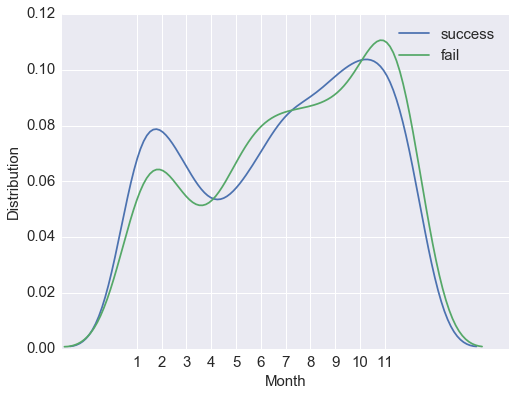

In [54]:
plt.figure(figsize=(8,6));
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==True]['start_month'], label = 'success');
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==False]['start_month'], label = 'fail');
plt.xticks(range(1, 12), fontsize=15);
plt.yticks(fontsize=15);
plt.xlabel('Month', fontsize=15);
plt.ylabel('Distribution', fontsize = 15);
plt.legend(fontsize = 15);

In [55]:
# Ks_2sampResult : Kolmogorov-Smirnov test
# Ttest_indResult : 2 sample T-test
success_month = cf_df.loc[cf_df['end_with_success'] ==True]['start_month']
fail_month = cf_df.loc[cf_df['end_with_success'] ==False]['start_month']
print(sp.stats.ks_2samp(success_month, fail_month))
print(sp.stats.ttest_ind(success_month, fail_month))

Ks_2sampResult(statistic=0.052869878916033397, pvalue=0.10624009393771351)
Ttest_indResult(statistic=-2.3759975226000387, pvalue=0.017586367162689347)


같은 분포이지만 평균은 차이가 있다.

funding_duration

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


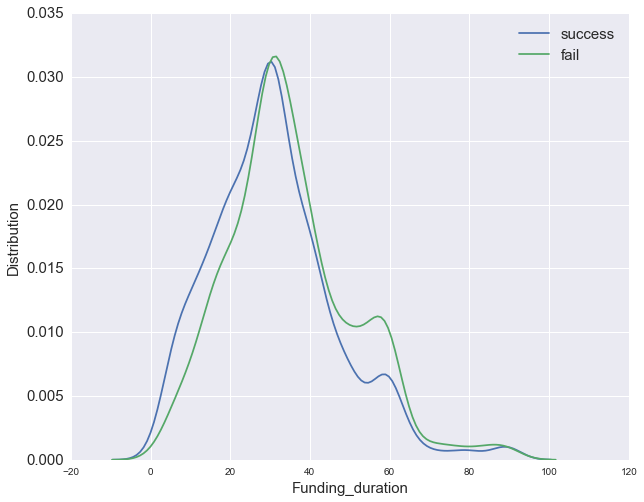

In [56]:
plt.figure(figsize=(10,8));
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==True]['funding_duration'], label = 'success');
sns.kdeplot(cf_df.loc[cf_df['end_with_success'] ==False]['funding_duration'], label = 'fail');
plt.yticks(fontsize=15);
plt.xlabel('Funding_duration', fontsize=15);
plt.ylabel('Distribution', fontsize = 15);
plt.legend(fontsize = 15);

In [57]:
# Ks_2sampResult : Kolmogorov-Smirnov test
# Ttest_indResult : 2 sample T-test
success_duration = cf_df.loc[cf_df['end_with_success'] ==True]['funding_duration']
fail_duration = cf_df.loc[cf_df['end_with_success'] ==False]['funding_duration']
print(sp.stats.ks_2samp(success_duration, fail_duration))
print(sp.stats.ttest_ind(success_duration, fail_duration))

Ks_2sampResult(statistic=0.12289992138987577, pvalue=2.5890164134690636e-07)
Ttest_indResult(statistic=-5.9479039022936844, pvalue=3.1490116777196017e-09)


평균과 분포가 차이가 있다

Label Encoding

In [58]:
from sklearn.preprocessing import LabelEncoder

In [59]:
le = LabelEncoder()

In [60]:
cf_df['category_label'] = le.fit_transform(cf_df['category'])

In [63]:
category_class = le.classes_
category_class

array(['art', 'comics', 'comics publishing', 'dance', 'design', 'etc',
       'fashion', 'game', 'movie/video', 'music', 'photo', 'publishing',
       'tech', 'theater'], dtype=object)

## 2. Feature selection
- According to proeject result, incorrent feaure selection leads to high variance of accuracy
- We treat this part importantly
- 앞서 실시했던 project의 결과, 잘못된 feature의 선택은 accuracy를 크게 변화시키는 경향을 보인다.
- feature selection 방법론을 중요하게 다룰 것임

### A. Variables Selection

In [64]:
# all features
x = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video'], cf_df['grammar_level'],
                 cf_df['start_month'], cf_df['funding_duration'],
                 cf_df['num_funding_type']]).T

In [65]:
#no month, duration, num_funding_type
x_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video'], cf_df['grammar_level']]).T

In [66]:
#no month, duration, num_funding_type, grammar
x_no_grammar = pd.DataFrame([cf_df['category_label'], cf_df['target_money'], 
                  cf_df['has_video']]).T

In [67]:
y = cf_df['end_with_success']

In [68]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

### B. SelectKBest
- Univariate feature selection
    - Univariate feature selection works by selecting the best features based on univariate statistical tests
- Removes all but the K-highest scoring features
- Scoring Function
    - f_classif : Compute the ANOVA F-value for the provided sample.


In [69]:
x_kbest = SelectKBest(f_classif, k=4).fit_transform(x, y)
x_kbest

array([[  2.00442500e+06,   0.00000000e+00,   5.00000000e+00,
          5.00000000e+01],
       [  5.00294100e+06,   1.00000000e+00,   5.00000000e+00,
          9.00000000e+01],
       [  1.00000000e+06,   1.00000000e+00,   5.00000000e+00,
          6.00000000e+01],
       ..., 
       [  1.00040700e+06,   0.00000000e+00,   3.00000000e+00,
          1.90000000e+01],
       [  4.67058800e+06,   0.00000000e+00,   3.00000000e+00,
          4.00000000e+01],
       [  1.00000000e+05,   0.00000000e+00,   3.00000000e+00,
          2.00000000e+00]])

* when using k=4, (***target_money, funding_duration, start_month, has_video***) are selected

### C. Correlation

In [70]:
x_categories = pd.DataFrame([x['category_label'], x['has_video'], x['start_month']]).T
x_nominal = pd.DataFrame([x['target_money'], x['grammar_level'], x['funding_duration'],
                         x['num_funding_type']]).T

                category_label  has_video  start_month
category_label        1.000000   0.077431    -0.093077
has_video             0.077431   1.000000    -0.060863
start_month          -0.093077  -0.060863     1.000000


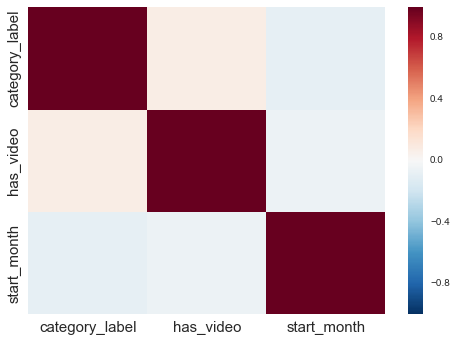

In [71]:
category_corr = x_categories.corr(method='spearman')
print(category_corr);
sns.heatmap(category_corr);
plt.xticks(fontsize = 15);
plt.yticks(fontsize = 15);

                  target_money  grammar_level  funding_duration  \
target_money          1.000000      -0.070147          0.298985   
grammar_level        -0.070147       1.000000         -0.087444   
funding_duration      0.298985      -0.087444          1.000000   
num_funding_type      0.129247      -0.050219          0.186218   

                  num_funding_type  
target_money              0.129247  
grammar_level            -0.050219  
funding_duration          0.186218  
num_funding_type          1.000000  


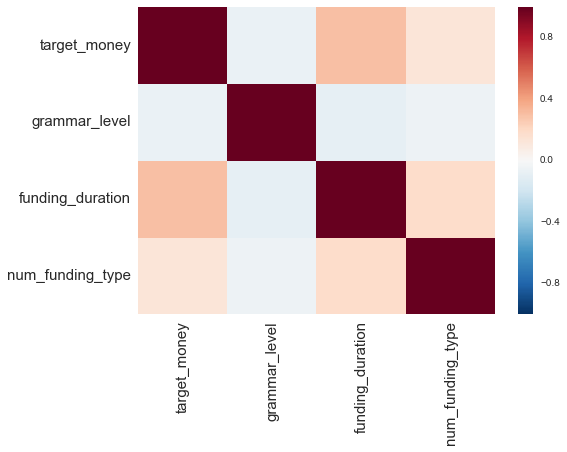

In [72]:
nominal_corr = x_nominal.corr(method='pearson')
print(nominal_corr)
sns.heatmap(nominal_corr);
plt.xticks(fontsize = 15, rotation='vertical');
plt.yticks(fontsize = 15);

- As a result, ***(target_money, funding_duration, num_funding_type)*** are highly correlated
- According to correlation theory, one variable could be used among ***(target_money, funding_duration, num_funding_type)***
- Candidates are ***target_money, grammar_level, category_label, has_video, start_month***

### D. Feature Importance (Random Forest)
- Ease of use
- Relatively good accuracy
- Robustness

In [76]:
re = RandomForestClassifier()

In [89]:
re.fit(x, y)
feature_importance = pd.DataFrame()
for i in np.arange(len(x.columns)):
    if re.feature_importances_[i] >= 0.1:
        fi = pd.DataFrame([x.columns[i], re.feature_importances_[i]], 
                          index = ['features', 'importance']).T
        feature_importance = feature_importance.append(fi)

feature_importance.index = np.arange(len(feature_importance))
feature_importance

,features,importance
0,target_money,0.287442
1,grammar_level,0.196941
2,start_month,0.109999
3,funding_duration,0.179454


- *** target_money, grammar_level, funding_duration, start_month*** are selected
- But it's always changed as model fits

### E. Mean decrease accuracy
- Directly measure the impact of each feature on accuracy of the model
- For unimportant variables, the permutation should have little to no effect on model accuracy
- Base model = RandomForest

In [91]:
from sklearn.cross_validation import ShuffleSplit
from collections import defaultdict

re_1 = RandomForestClassifier(n_estimators=20)
scores = defaultdict(list)
names = x.columns

#crossvalidate the scores on a number of different random splits of the data
for train_idx, test_idx in ShuffleSplit(len(x), 20, .3):
    X_train, X_test = x.ix[train_idx], x.ix[test_idx]
    Y_train, Y_test = y.ix[train_idx], y.ix[test_idx]
    r = re.fit(X_train, Y_train)
    acc = re.score(X_test, Y_test)
    for i in x.columns:
        X_drop_train = X_train.drop([i], axis=1)
        X_drop_test = X_test.drop([i], axis=1)
        re_1.fit(X_drop_train, Y_train)
        shuff_acc = round(re_1.score(X_drop_test, Y_test), 4)
        scores[i].append(round((acc-shuff_acc)/acc, 4))

print ("Features sorted by their score:"),
print (pd.DataFrame([sorted([(feat, round(np.mean(score), 4)) for feat, score in scores.items()], 
                            reverse=True)], index = ['score']).T)

Features sorted by their score:
                         score
0       (target_money, 0.0843)
1       (start_month, -0.0577)
2  (num_funding_type, -0.0407)
3         (has_video, -0.0445)
4     (grammar_level, -0.0556)
5  (funding_duration, -0.0511)
6    (category_label, -0.0507)


- (-) score means accuracy increases without a variable
- Only ***target_money*** is selected

### F. RFE (Recursive Feature Estimation)
- Repeatedly construct a model and choose either the best or worst performing feature 
- Base model = RandomForest

In [114]:
from sklearn.feature_selection import RFE

In [113]:
names = x.columns
 
rfe = RFE(re)
rfe.fit(x, y)
 
print ("Features sorted by their rank"),
pd.DataFrame([sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))], 
             index=['Ranking']).T

Features sorted by their rank


,Ranking
0,"(1, funding_duration)"
1,"(1, grammar_level)"
2,"(1, target_money)"
3,"(2, start_month)"
4,"(3, category_label)"
5,"(4, num_funding_type)"
6,"(5, has_video)"


### G. # Result

- Kbest = ***target_money, funding_duration, start_month, has_video***
- Correlation = ***target_money, grammar_level, start_month, has_video, category_label***
- Feature Importance =  ***target_money, grammar_level, funding_duration, start_month***
- Mean decrese accuracy = ***target_money***
- Reculsive Feature Estimation =  ***target_money, grammar_level, funding_duration, start_month, category_label***
- Rank : ***target_money > start_month > grammar_level > funding_duration > category_label = has_video***

- 'num_funding_type' may be unimportant
- Final Selection
    - 4 features : target_money, start_month, grammar_level, funding_duration
    - 5 features : target_money, start_month, grammar_level, funding_duration, category_label(or has_video)

## 3. Model Selection (Classification)
- Random Forest
- Decision Tree
- SVM
- Gaussian Naive Bayes
- 

In [125]:
# using features
x_4 = pd.DataFrame([cf_df['target_money'], cf_df['start_month'],
                           cf_df['grammar_level'], cf_df['funding_duration']]).T
x_5 = pd.DataFrame([cf_df['target_money'], cf_df['start_month'],
                           cf_df['grammar_level'], cf_df['funding_duration'], 
                           cf_df['category_label']]).T

In [ ]:
success_percentage = y.value_counts()[1] / len(y)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
re = RandomForestClassifier(n_estimators=100)

In [ ]:
from sklearn.cross_validation import train_test_split

In [ ]:
from sklearn.cross_validation import cross_val_score

In [ ]:
cross_val_score(re, x_1, y, cv=10).mean()

In [ ]:
cross_val_score(re, x_2, y, cv=10).mean()

In [ ]:
cross_val_score(re, x, y, cv=10).mean()

In [ ]:
re.fit(x, y)

In [ ]:
re.fit(x, y)
pd.DataFrame(re.feature_importances_, x.columns, columns=['feature_importance'])

In [ ]:
re.fit(x_1, y)
pd.DataFrame(re.feature_importances_, x_1.columns, columns=['feature_importance'])

In [ ]:
re.fit(x_2, y)
pd.DataFrame(re.feature_importances_, x_2.columns, columns=['feature_importance'])

wadiz after funding -> 날짜별 comment, day funding_rate의 상대적 중요성

In [ ]:
x_1 = pd.DataFrame([tb_grammar_df['category'], tb_grammar_df['target_money'], tb_grammar_df['has_video']]).T

In [ ]:
x_1['category_label'] = le.fit_transform(x_1['category'])
x_1.drop(['category'], axis=1, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_1, y)
re.fit(x_train, y_train)
re.score(x_test, y_test)

In [ ]:
from sklearn.cross_validation import cross_val_score

In [ ]:
x_grammar = []
y_grammar = []
figure = plt.figure(figsize=(15,10))
for i in range(1, 100
    re_1 = RandomForestClassifier(n_estimators=i)
    a = cross_val_score(re, x, y, cv=10)
    b = a.sum() / 10
    x_grammar.append(i)
    y_grammar.append(b)
    #print(b)
    #plt.scatter(i, b, c='r')
plt.plot(x_grammar, y_grammar, 'o--', c='r')
plt.xlabel('n_estimator', fontsize=20)
plt.axhline(y = success_percentage)
plt.ylabel('accuracy', fontsize=20)
print('max_accuracy(with_grammar_level) :', round(max(y_grammar)*100, 2), '%'),

In [ ]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold

In [ ]:
from sklearn.cross_validation import StratifiedKFold

In [ ]:
re = RandomForestClassifier()

In [ ]:
a = cross_val_score(re, x, y, cv=10)
a.sum() / 10

In [ ]:
b = cross_val_score(re, x_1, y, cv=10)
b.sum() / 10

In [ ]:
x_list = []
y_list = []
x_grammar = []
y_grammar = []
figure = plt.figure(figsize=(15,10))
legend =['with_grammar', 'without_grammar'] 
for i in range(1, 50):
    re_1 = RandomForestClassifier(n_estimators=i)
    a = cross_val_score(re_1, x, y, cv=10)
    b = a.sum() / 10
    x_grammar.append(i)
    y_grammar.append(b)
    #print(b)
    #plt.scatter(i, b, c='r')
plt.plot(x_grammar, y_grammar, 'o--', c='r')


for i in range(1, 50):
    re_2 = RandomForestClassifier(n_estimators=i)
    a = cross_val_score(re_2, x_1, y, cv=10)
    b = a.sum() / 10
    x_list.append(i)
    y_list.append(b)
    #print(b)
    #plt.scatter(i, b, c='y' )
plt.plot(x_list, y_list, 'o--', c = 'y')
plt.legend(legend, loc=5, fontsize=20)
plt.xlabel('n_estimator', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
print('max_accuracy(with_grammar_level) :', round(max(y_grammar)*100, 2), '%'),
print('max_accuracy(no_grammar_level) :', round(max(y_list)*100, 2), '%')

In [ ]:
tb_grammar_df['log_grammar'] = tb_grammar_df['grammar_level'].apply(lambda x: np.log(x))

In [ ]:
sns.kdeplot(tb_grammar_df.loc[tb_grammar_df['end_with_success'] == True]['log_grammar'], label = 'success')
sns.kdeplot(tb_grammar_df.loc[tb_grammar_df['end_with_success'] == False]['log_grammar'], label = 'fail')

In [ ]:
re_1.fit(x, y)

In [ ]:
for_prob = [1000000, True, 0.2, 1]

In [ ]:
print(re_1.classes_)
print(re_1.predict_proba(for_prob))

In [ ]:
#각 카테고리별 맞춤법 정확도

In [ ]:
#분포의 수치 계산
for i in tb_df['category'].unique():
    sns.kdeplot(tb_grammar_df.loc[tb_grammar_df['category'] == i]['grammar_level'], label=i)

In [ ]:
tb_grammar_df['category'].value_counts()

In [ ]:
sns.kdeplot(tb_grammar_df.loc[tb_grammar_df['category'] == 'comics']['grammar_level'], label='comics')

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
gnb = GaussianNB()
knn = KNeighborsClassifier()

In [ ]:
import patsy

In [ ]:
gnb.fit(x_gnb_matrix, y_gnb)

In [ ]:
gnb.score(x_gnb_matrix, y_gnb)

In [ ]:
x_gnb_list=[]
y_gnb_list=[]
for i in range(3, 200):
    gnb_score = round(((cross_val_score(gnb, x_gnb_matrix, y_gnb, cv=i)).sum())/i, 6)
    x_gnb_list.append(i)
    y_gnb_list.append(gnb_score)
print('gnb_max_score :', max(y_gnb_list)*100, '%')
print('gnb_min_score :', min(y_gnb_list)*100, '%')
figure = plt.figure(figsize=(15,10))
legend =['gnb_score'] 
plt.plot(x_gnb_list, y_gnb_list, 'o--', c = 'r')
plt.legend(legend, fontsize=20)
plt.xlabel('cv', fontsize=20)
plt.ylabel('accuracy', fontsize=20)

In [ ]:
x_knn_list=[]
y_knn_list=[]
for i in range(3, 200):
    knn_score = round(((cross_val_score(knn, x_gnb_matrix, y_gnb, cv=i)).sum())/i, 6)
    x_knn_list.append(i)
    y_knn_list.append(knn_score)
print('knn_max_score :', max(y_knn_list)*100, '%')
print('knn_min_score :', min(y_knn_list)*100, '%')
figure = plt.figure(figsize=(15,10))
legend =['knn_score'] 
plt.plot(x_knn_list, y_knn_list, 'o--', c = 'r')
plt.legend(legend, fontsize=20)
plt.xlabel('cv', fontsize=20)
plt.ylabel('accuracy', fontsize=20)

In [ ]:
from sklearn.grid_search import GridSearchCV

In [ ]:
re

In [ ]:
parameters = {'n_estimators': [1, 200]}

In [ ]:
gs = GridSearchCV(re, parameters, cv=10)

In [ ]:
gs

In [ ]:
gs.fit(x, y)

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_score_

In [ ]:
gs.best_params_

In [ ]:
np.mean(cross_val_score(re, x, y, cv=10))

In [ ]:
gs

In [ ]:
import gensim